# Hosting Detectron2 model on Sagemaker Inference endpoint

In this notebook we'll package previously trained model into PyTorch Serving container and deploy it on Sagemaker. First, let's review serving container. There are two key difference comparing to training container:
- we are using different base container provided by Sagemaker;
- we need to start Web server (refer to ENTRYPOINT command).

In [4]:
! pygmentize -l docker Dockerfile.serving

# Build an image of Detectron2 that can do distributing training on Amazon Sagemaker 

# using Sagemaker PyTorch container as base image
# https://github.com/aws/sagemaker-pytorch-container/blob/master/docker/1.4.0/py3/Dockerfile.gpu
FROM 763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.4.0-gpu-py36-cu101-ubuntu16.04
LABEL author="vadimd@amazon.com"

############# Installing latest builds ############

# This is to fix issue: https://github.com/pytorch/vision/issues/1489
RUN pip install --upgrade --force-reinstall torch torchvision cython
RUN pip install sagemaker sagemaker_inference # needed for debug purposes only

############# D2 section ##############

# installing dependecies for D2 https://github.com/facebookresearch/detectron2/blob/master/docker/Dockerfile
RUN pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
RUN pip install 'git+https://github.com/facebookresearch/fvcore'

ENV FORCE_CUDA="1"
# Build D2 only for Volta architectu

As in case of training image, we'll need to build and push container to AWS ECR. Before this, we'll need to loging to shared Sagemaker ECR and your local ECR

In [5]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-2.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-2.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Now, let's build and push container using follow command. Note, that here we supply non-default Dockerfile.

In [ ]:
! ./build_and_push.sh d2-sm-coco-serving latest Dockerfile.serving

# Preparing test data

We'll be using coco2017 validation dataset. To simplify working with it, let's install locally Pycoco package

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Now, let's download Coco2017 validation dataset

In [9]:
data_dir = "../datasets/coco/" # folder where data will be saved
dataset  = "val2017"

In [ ]:
! mkdir -p {data_dir}{dataset}
! wget http://images.cocodataset.org/zips/val2017.zip -P {data_dir}
! unzip {data_dir}/val2017.zip -d {data_dir}

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {data_dir}
! unzip {data_dir}/annotations_trainval2017.zip -d {data_dir}{dataset}

Let's get a random image ...

In [21]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

annFile='{}{}/annotations/instances_{}.json'.format(data_dir,dataset, dataset)
coco=COCO(annFile)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds);
imgId = imgIds[np.random.randint(len(imgIds))]
image_instance = coco.loadImgs(imgId)[0]
image_np = io.imread(image_instance['coco_url'])    

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


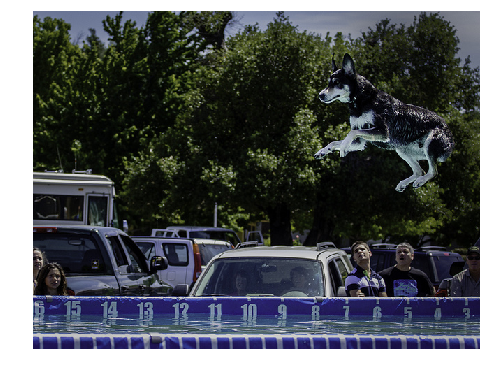

In [22]:
plt.axis('off')
plt.imshow(image_np)
plt.show()

# Testing inference script locally

Let's first check what inference script we'll deploy:

In [33]:
!pygmentize container_serving/predict_coco.py

# This is default implementation of inference_handler: 
# https://github.com/aws/sagemaker-pytorch-serving-container/blob/master/src/sagemaker_pytorch_serving_container/default_inference_handler.py
# SM specs: https://sagemaker.readthedocs.io/en/stable/using_pytorch.html


# TODO list
# 1. add support of multi-GPU instances - if GPU devices > 1, do round robin
# 2. do we need to support checkpoints (optimizers, LR etc.)


from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
import detectron2.data.transforms as T
import torch
import numpy as np
import cv2 # TODO: delete

from sagemaker_inference import content_types, decoder, default_inference_handler, encoder
from sagemaker.content_types import CONTENT_TYPE_JSON, CONTENT_TYPE_CSV, CONTENT_TYPE_NPY # TODO: for local debug only. Remove 

To test inference pipeline locally, you can run your `container_serving/predict_coco.py` locally (only code in __main__ guard will be executed). You'll need to have Detectron2 and number other packages locally installed to test it.

Make sure that you pass correct --model-dir argument.

In [40]:
!python container_serving/predict_coco.py --data-dir {data_dir} --model-dir ../model2_dir

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
{'instances': Instances(num_instances=59, image_height=485, image_width=640, fields=[pred_boxes = Boxes(tensor([[4.0107e+02, 5.8874e+01, 5.9809e+02, 2.6838e+02],
        [4.9131e+02, 3.3339e+02, 5.7718e+02, 4.1023e+02],
        [5.9610e+02, 3.3644e+02, 6.3907e+02, 4.1339e+02],
        [4.4144e+02, 3.3151e+02, 5.1075e+02, 4.1077e+02],
        [2.8320e+00, 3.0350e+02, 1.9873e+02, 4.1228e+02],
        [3.5455e+02, 3.6620e+02, 4.0584e+02, 4.0945e+02],
        [0.0000e+00, 2.3022e+02, 1.2588e+02, 3.1831e+02],
        [2.1501e+02, 3.3733e+02, 4.6862e+02, 4.2620e+02],
        [1.4099e+02, 3.1873e+02, 2.8325e+02, 4.0103e+02],
        [2.8626e+02, 3.3054e+02, 3.2513e+02, 3.4197e+02],
        [2.4266e+00, 3.5907e+02, 5.3658e+01, 4.1004e+02],
        [5.0027e+02, 3.3708e+02, 6.0664e+02, 4.0336e+02],
        [1.4900e+02, 3.1292e+02, 2.9288e+02, 3.9930e+02],
        [1.2682e+02, 3.3761e+02, 6.1778e+02, 4.5970e+02],
 

# Deploying endpoint

Below is some initial imports and configuration.

In [26]:
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

In [27]:
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-ouput'

## Define parameters of your container

In [29]:
container_serving = "d2-sm-coco-serving" # your container name
tag = "debug" # you can have several version of container available
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag)

print("Following container will be used for hosting: ",image)

Following container will be used for hosting:  553020858742.dkr.ecr.us-east-2.amazonaws.com/d2-sm-coco-serving:debug


## Creating ndpoint from model artifact

As training on COCO2017 can be quite lenghty, we'll deploy our endpoint from model artifacts from already completed training jobs. Please review your training jobs, and find one which succesffuly completed. Then, copy model artifact S3 URI and.  pass it to `model_data` argument below.

In [31]:
from sagemaker.pytorch import PyTorchModel, PyTorch

model = PyTorchModel(model_data="s3://sagemaker-us-east-2-553020858742/detectron2-ouput/d2-sm-coco-2020-04-18-18-16-08-142/output/model.tar.gz",
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

In [32]:
predictor = model.deploy(instance_type='ml.p3.16xlarge', 
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-v9", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=True
                         )

-------------------!

In [41]:
# Let send prediction request using previously fetched image. 

response = predictor.predict(image_np)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "__init__() takes 2 positional arguments but 3 were given". See https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logEventViewer:group=/aws/sagemaker/Endpoints/d2-sm-coco-serving-v9 in account 553020858742 for more information.